# Binary Task - Emotion Recognition

In [45]:
import time
import os
import cv2

import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import datasets, classifiers and performance metrics
from sklearn import svm, metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

%matplotlib inline

# setting user chosen vars
images_dir = './new_dataset'
labels_filename = 'attribute_list.csv'
# user choses grey scale or not, 0 for yes, 1 for no
grey_scale = 1


data_preprocessing: 
- https://datascience.stackexchange.com/questions/26881/data-preprocessing-should-we-normalise-images-pixel-wise
- https://stackoverflow.com/questions/41428868/image-preprocessing-in-deep-learning
- https://becominghuman.ai/image-data-pre-processing-for-neural-networks-498289068258
- https://stackoverflow.com/questions/50584353/image-mean-subtraction/50585147 - mean subtraction

- image rescaling (zooming) will not be necessary as the frontal faces are all zommed in already and cover the full frontal face without any further processing needed. It is true however that some images do contain some abnormal noise in the background, behind the faces (or even occlusive elemnts on the face itself - like watermarks or arms covering part of the mouth and such)

In [46]:
# Import whole pre-processed Dataset (training and test)

# lists keep the order
full_dataset = []
full_labels = []

# collect labels
df = pd.read_csv(labels_filename, skiprows=1, index_col='file_name')
newdf = df[df.columns[2]] 

# collect pre-processed images and sort them to labels
for (root, dirs, dat_files) in os.walk('{0}'.format(images_dir)):
     
    for file in dat_files:
        # image grayscaling at import
        img = cv2.imread('{0}/{1}'.format(images_dir, file), grey_scale)
        # image equalisation
        # rescaling image (you can use cv2)
        res = cv2.resize(img, dsize=(128, 128), interpolation=cv2.INTER_LINEAR)
        # turn to float for zero centering
        res = res.astype(float)
        full_dataset.append(res)
        full_labels.append(int(file[:-4]))

# only select rows of interest (none outliers) and only keep 'smiling' feature to be evaluated
full_labels = newdf.loc[full_labels]
full_labels = full_labels.values.tolist() 

# now both of our dataset and labels are ordered 

# numpy array conversion
full_dataset = np.array(full_dataset)
full_labels = np.array(full_labels)

print('full dataset of shape:', full_dataset.shape)
print('full labels of shape:', full_labels.shape)

full dataset of shape: (4546, 128, 128, 3)
full labels of shape: (4546,)


In [47]:
# plt.imshow(full_dataset[0])
full_dataset[0]

array([[[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       ..., 
       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.]],

       [[ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        ..., 
        [ 255.,  255.,  255.],
        [ 255.,  255.,  255.],
        [ 

In [48]:
# Reshuffling data (just in case)
X_data, Y_data = shuffle(full_dataset, full_labels, random_state=0)

print('X_data of shape:', X_data.shape)
print('Y_data of shape:', Y_data.shape)

X_data of shape: (4546, 128, 128, 3)
Y_data of shape: (4546,)


In [50]:
# perform train and test split
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data, test_size=0.2)

print('X_train of shape:', X_train.shape)
print('y_train of shape:', y_train.shape)
print('X_test of shape:', X_test.shape)
print('y_test of shape:', y_test.shape)

X_train of shape: (3636, 128, 128, 3)
y_train of shape: (3636,)
X_test of shape: (910, 128, 128, 3)
y_test of shape: (910,)


X_train of shape: (3636, 49152)
X_test of shape: (910, 49152)
[ 255.  255.  255. ...,  255.  255.  255.]
[ 188.33525853  191.92821782  195.74834983  190.01705171  193.60011001
  197.52310231  190.97992299  194.62046205  198.56710671  191.48239824]


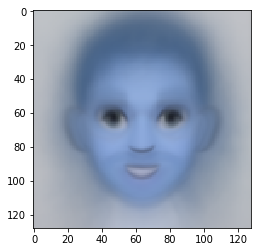

In [51]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print('X_train of shape:', X_train.shape)
print('X_test of shape:', X_test.shape)

print(X_train[0])

# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((128,128,3)).astype('uint8')) # visualize the mean image
plt.show()

In [52]:
# second: subtract the mean image from train and test data
print(mean_image.shape)
X_train -= mean_image
X_test -= mean_image
print(X_train)

(49152,)
[[  66.66474147   63.07178218   59.25165017 ...,   74.41721672
    71.63778878   65.98184818]
 [  66.66474147   63.07178218   59.25165017 ...,   74.41721672
    71.63778878   65.98184818]
 [  66.66474147   63.07178218   59.25165017 ...,   74.41721672
    71.63778878   65.98184818]
 ..., 
 [  66.66474147   63.07178218   59.25165017 ...,   74.41721672
    71.63778878   65.98184818]
 [  66.66474147   63.07178218   59.25165017 ...,   74.41721672
    71.63778878   65.98184818]
 [-137.33525853  -53.92821782  -11.74834983 ..., -102.58278328
  -114.36221122 -109.01815182]]


In [ ]:
classifier = svm.SVC(C=1, kernel='linear',cache_size=8000,probability=False)

start_time = dt.datetime.now()
print('Start learning at {}'.format(str(start_time)))

classifier.fit(X_train, y_train)

end_time = dt.datetime.now() 
print('Stop learning {}'.format(str(end_time)))
elapsed_time= end_time - start_time
print('Elapsed learning {}'.format(str(elapsed_time)))

Start learning at 2018-12-26 16:51:02.117678


In [ ]:
# Now predict the value of the test
expected = y_test
predicted = classifier.predict(X_test)


print("Classification report for classifier %s:\n%s\n"
      % (classifier, metrics.classification_report(expected, predicted)))
      
cm = metrics.confusion_matrix(expected, predicted)
print("Confusion matrix:\n%s" % cm)

# plot_confusion_matrix(cm)

print("Accuracy={}".format(metrics.accuracy_score(expected, predicted)))